In [1]:
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn tensorflow keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# LSTM

In [152]:
# Load dataset (Modify the filename accordingly)
df = pd.read_csv("/kaggle/input/iot-sensor-data-cleaned-dataset/sensor_df10m_final.csv")

# Set index for 'Server_Date'
df.set_index('Server_Date', inplace=True)

# Sort the dataset by datetime
df = df.sort_index()

df.head()

,Voltage,Power,Frequency,Energy,Power_Factor
Server_Date,,,,,
01/06/21 00:00,120.038603,97.853625,59.958916,60.396625,0.862941
01/06/21 00:10,120.028838,97.860166,59.959903,60.414208,0.863024
01/06/21 00:20,120.027976,97.823628,59.968784,60.429668,0.864488
01/06/21 00:30,120.030395,97.879546,59.967857,60.445304,0.864528
01/06/21 00:40,120.023230,98.328174,59.962697,60.463541,0.864728


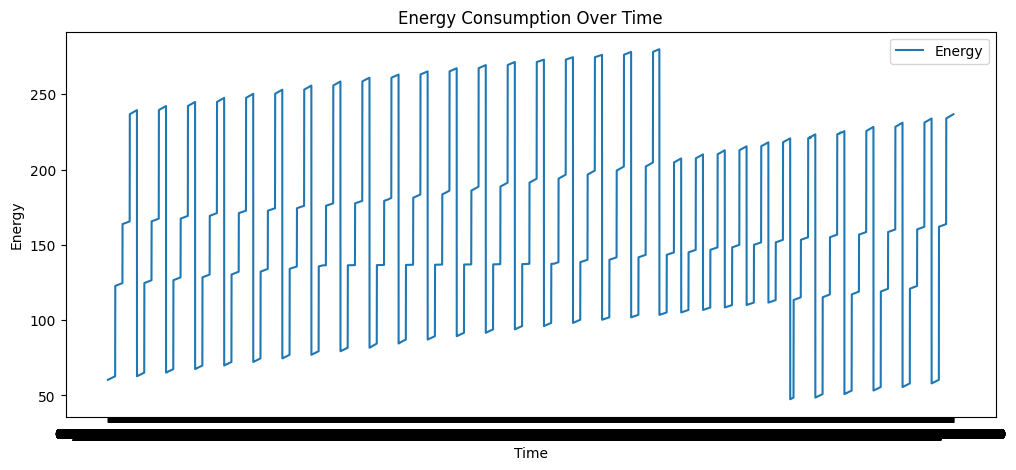

In [30]:
# Plot the energy time series
plt.figure(figsize=(12, 5))
plt.plot(df['Energy'], label='Energy')
plt.title("Energy Consumption Over Time")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.show()

In [31]:
# Feature Scaling
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['Energy']])

In [32]:
# Convert to supervised learning format
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [33]:
sequence_length = 10
X, y = create_sequences(df_scaled, sequence_length)

In [34]:
# Split into train and test sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [57]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/30
419/419 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.3240 - val_loss: 0.0140
Epoch 2/30
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0139 - val_loss: 0.0112
Epoch 3/30
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 4/30
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0106 - val_loss: 0.0082
Epoch 5/30
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0100 - val_loss: 0.0078
Epoch 6/30
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0095 - val_loss: 0.0090
Epoch 7/30
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 8/30
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0098 - val_loss: 0.0089
Epoch 9/30
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 10/30
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0080 - val_loss: 0.0087


In [54]:
y_pred = model.predict(X_test)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


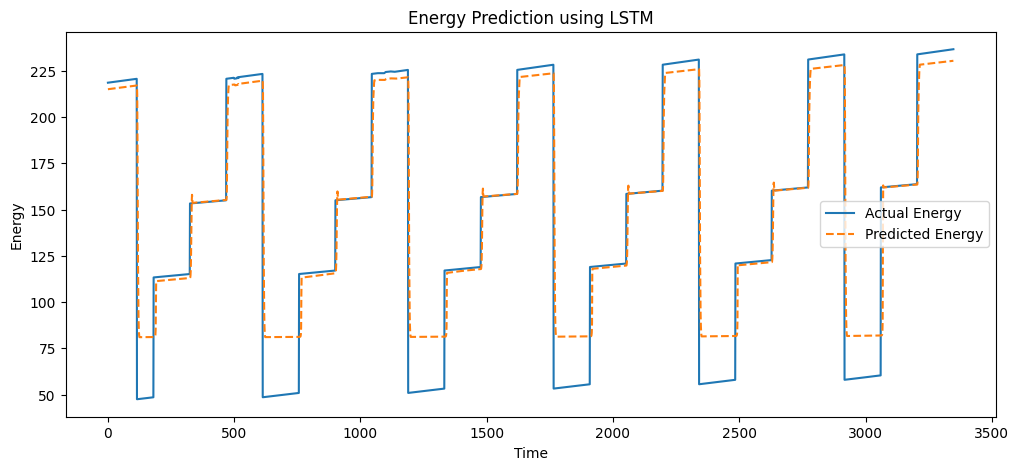

In [58]:
# Rescale predictions back to original scale
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Plot Predictions vs Actual
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label="Actual Energy")
plt.plot(y_pred_inv, label="Predicted Energy", linestyle='dashed')
plt.title("Energy Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.show()

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 10.58007095069319
MSE: 418.5062429798876
RMSE: 20.457425130741345


# Random Forest Regression without Sliding Window Approach (it takes all the timestamps for prediction)

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 2: Feature Engineering (Lag Features + Rolling Statistics)
def create_features(df, target_col='Energy', lags=5, rolling_window=3):
    df = df.copy()
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df[target_col].shift(i)  # Create lag features
    
    df[f'rolling_mean'] = df[target_col].rolling(window=rolling_window).mean()
    df[f'rolling_std'] = df[target_col].rolling(window=rolling_window).std()
    
    df.dropna(inplace=True)  # Drop NaN values caused by shifting
    return df

# Apply feature engineering
sensor_df = create_features(df)

In [61]:
sensor_df.head()

,Voltage,Power,Frequency,Energy,Power_Factor,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean,rolling_std
Server_Date,,,,,,,,,,,,
01/06/21 00:50,120.029392,97.752450,59.958791,60.478465,0.862297,60.463541,60.445304,60.429668,60.414208,60.396625,60.462437,0.016608
01/06/21 01:00,120.034417,97.773844,59.967904,60.494714,0.862341,60.478465,60.463541,60.445304,60.429668,60.414208,60.478907,0.015591
01/06/21 01:10,120.027494,98.149978,59.961516,60.511688,0.863154,60.494714,60.478465,60.463541,60.445304,60.429668,60.494956,0.016613
01/06/21 01:20,120.032340,97.719079,59.978327,60.527214,0.862199,60.511688,60.494714,60.478465,60.463541,60.445304,60.511206,0.016255
01/06/21 01:30,120.027005,97.850921,59.946143,60.544070,0.862798,60.527214,60.511688,60.494714,60.478465,60.463541,60.527657,0.016196


In [70]:
sensor_df.shape

(16749, 12)

In [63]:
# Step 3: Prepare Data for Training
X = sensor_df.drop(columns=['Energy'])  # Features
y = sensor_df['Energy']  # Target variable

# Split into Train & Test (80%-20% time-based split)
train_size = int(len(sensor_df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [64]:
# Step 4: Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [65]:
# Step 5: Make Predictions
y_pred = rf_model.predict(X_test)

In [66]:
# Step 6: Evaluate Model Performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 10.4198
RMSE: 15.9521


In [75]:
# Step 7: Predict Future Values and Compare with Actuals
future_df = sensor_df.copy()  # Take last known values
actual_values = future_df['Energy'].values  # Get actual Energy values
future_df.drop(columns=['Energy'], inplace=True)  # Drop target column before prediction

# Make Predictions
future_predictions = rf_model.predict(future_df)

# Display Actual vs Predicted Values
future_results = pd.DataFrame({
    'Timestamp': future_df.index,  # Get the datetime index
    'Actual Energy': actual_values,
    'Predicted Energy': future_predictions
})

future_results.to_csv("RF_Regressor_Predictions.csv")

In [78]:
future_results.head(50)

,Timestamp,Actual Energy,Predicted Energy
0,01/06/21 00:50,60.478465,60.487811
1,01/06/21 01:00,60.494714,60.504280
2,01/06/21 01:10,60.511688,60.513143
3,01/06/21 01:20,60.527214,60.525917
4,01/06/21 01:30,60.544070,60.544363
5,01/06/21 01:40,60.560414,60.558672
6,01/06/21 01:50,60.576351,60.576181
7,01/06/21 02:00,60.593643,60.591093
8,01/06/21 02:10,60.609089,60.608923
9,01/06/21 02:20,60.628179,60.622818


In [80]:
future_results.tail(150)

,Timestamp,Actual Energy,Predicted Energy
16599,31/07/21 23:00,163.706375,163.825489
16600,31/07/21 23:10,163.717286,163.830197
16601,31/07/21 23:20,163.731719,163.823796
16602,31/07/21 23:30,163.742912,163.826968
16603,31/07/21 23:40,163.755625,163.825581
...,...,...,...
16744,31/08/21 23:10,236.636827,236.798435
16745,31/08/21 23:20,236.656251,236.798435
16746,31/08/21 23:30,236.675675,236.798435
16747,31/08/21 23:40,236.695099,236.798435


# Random Forest Regression with Sliding Window Approach (prediction happens only from the previous 5 results)

In [95]:
# Step 2: Function to create sliding window dataset
def create_sliding_window(df, target_col='Energy', window_size=5):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df[target_col].iloc[i:i + window_size].values)  # Take past `window_size` values
        y.append(df[target_col].iloc[i + window_size])  # Target value is the next step
    
    return np.array(X), np.array(y)

# Step 3: Prepare Train-Test Data
window_size = 5
X, y = create_sliding_window(df, window_size=window_size)

In [96]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 4: Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [97]:
# Step 5: Predict on Test Set
y_pred = rf_model.predict(X_test)

# Step 6: Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 10.9735
RMSE: 17.4739


In [105]:
# Step 7: Predict for Entire Dataset Using Sliding Window
def predict_full_series(model, df, target_col='Energy', window_size=5):
    predictions = [None] * window_size  # First `window_size` predictions will be None
    actual_values = df[target_col].values  # Get actual values

    for i in range(window_size, len(df)):  # Start from `window_size` index
        past_window = df[target_col].iloc[i - window_size:i].values.reshape(1, -1)  # Take past values
        pred = model.predict(past_window)[0]  # Predict the next value
        predictions.append(pred)

    # Create DataFrame for comparison
    result_df = pd.DataFrame({
        'Timestamp': df.index,
        'Actual Energy': actual_values,
        'Predicted Energy': predictions
    })

    return result_df

# Call the function to get predictions for the full dataset
full_predictions = predict_full_series(rf_model, df, window_size=window_size)

# Display results
full_predictions

,Timestamp,Actual Energy,Predicted Energy
0,01/06/21 00:00,60.396625,NaN
1,01/06/21 00:10,60.414208,NaN
2,01/06/21 00:20,60.429668,NaN
3,01/06/21 00:30,60.445304,NaN
4,01/06/21 00:40,60.463541,NaN
...,...,...,...
16749,31/08/21 23:10,236.636827,236.803097
16750,31/08/21 23:20,236.656251,236.803097
16751,31/08/21 23:30,236.675675,236.803097
16752,31/08/21 23:40,236.695099,236.803097


In [108]:
full_predictions.head(10)

,Timestamp,Actual Energy,Predicted Energy
0,01/06/21 00:00,60.396625,NaN
1,01/06/21 00:10,60.414208,NaN
2,01/06/21 00:20,60.429668,NaN
3,01/06/21 00:30,60.445304,NaN
4,01/06/21 00:40,60.463541,NaN
5,01/06/21 00:50,60.478465,60.485333
6,01/06/21 01:00,60.494714,60.493805
7,01/06/21 01:10,60.511688,60.510767
8,01/06/21 01:20,60.527214,60.524982
9,01/06/21 01:30,60.544070,60.541168


In [109]:
full_predictions.tail(150)

,Timestamp,Actual Energy,Predicted Energy
16604,31/07/21 23:00,163.706375,163.824666
16605,31/07/21 23:10,163.717286,163.824666
16606,31/07/21 23:20,163.731719,163.824666
16607,31/07/21 23:30,163.742912,163.824666
16608,31/07/21 23:40,163.755625,163.824666
...,...,...,...
16749,31/08/21 23:10,236.636827,236.803097
16750,31/08/21 23:20,236.656251,236.803097
16751,31/08/21 23:30,236.675675,236.803097
16752,31/08/21 23:40,236.695099,236.803097


In [110]:
full_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16754 entries, 0 to 16753
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Timestamp         16754 non-null  object 
 1   Actual Energy     16754 non-null  float64
 2   Predicted Energy  16749 non-null  float64
dtypes: float64(2), object(1)
memory usage: 392.8+ KB


In [111]:
full_predictions.to_csv("RF_Regressor_SlidingWindow.csv")

In [114]:
full_predictions.columns

Index(['Timestamp', 'Actual Energy', 'Predicted Energy'], dtype='object')

## Plot Actual vs Predicted Energy Graph

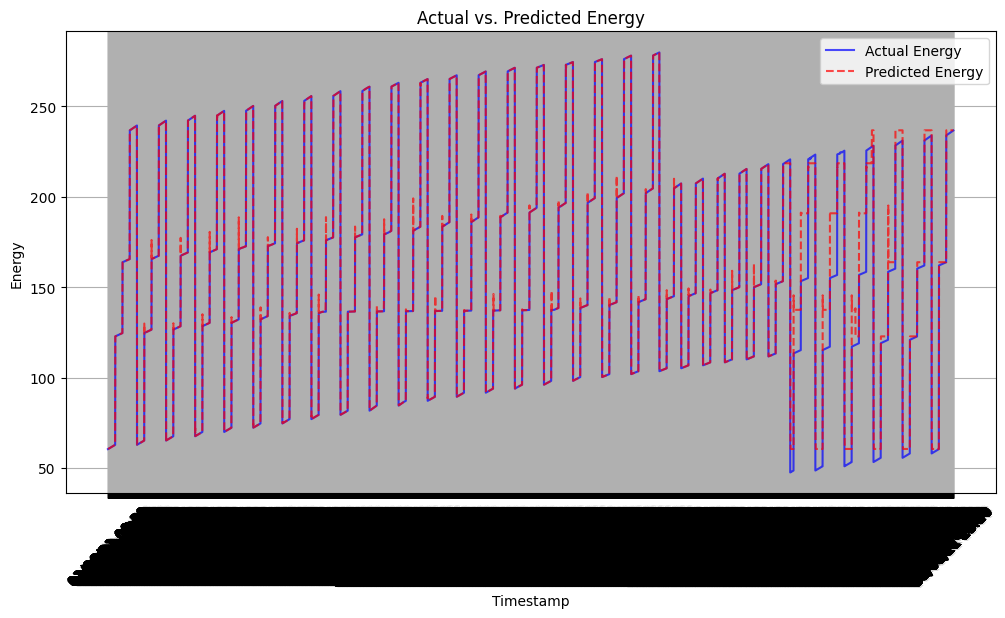

In [112]:
import matplotlib.pyplot as plt

# Step 8: Plot Actual vs. Predicted Energy
def plot_predictions(df, title="Actual vs. Predicted Energy"):
    plt.figure(figsize=(12, 6))
    
    # Plot actual values
    plt.plot(df['Timestamp'], df['Actual Energy'], label="Actual Energy", color='blue', alpha=0.7)
    
    # Plot predicted values (ignoring initial None values)
    plt.plot(df['Timestamp'], df['Predicted Energy'], label="Predicted Energy", color='red', linestyle='dashed', alpha=0.7)

    # Formatting
    plt.xlabel("Timestamp")
    plt.ylabel("Energy")
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Show plot
    plt.show()

# Call the function to plot results
plot_predictions(full_predictions)

In [115]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, DatetimeTickFormatter
from bokeh.palettes import Category10
import pandas as pd

output_notebook()

def plot_bokeh_predictions(data, x='Timestamp', y_actual='Actual Energy', y_pred='Predicted Energy'):
    # Convert timestamps to datetime if not already
    data[x] = pd.to_datetime(data[x])

    # Create figure
    p = figure(title="Actual vs. Predicted Energy",
               x_axis_label="Timestamp", 
               y_axis_label="Energy", 
               x_axis_type='datetime',
               width=1200, height=500, 
               background_fill_color='lightgrey')

    # Plot actual energy (solid line)
    p.line(data[x], data[y_actual], legend_label=y_actual, 
           line_width=2, line_color=Category10[3][0], alpha=0.8)

    # Plot predicted energy (dashed line)
    p.line(data[x], data[y_pred], legend_label=y_pred, 
           line_width=2, line_color=Category10[3][1], alpha=0.8, line_dash="dashed")

    # Add hover tool
    p.add_tools(HoverTool(tooltips=[("Date", "@x{%F %H:%M}"), 
                                    ("Actual", f"@{y_actual}"), 
                                    ("Predicted", f"@{y_pred}")],
                          formatters={'@x': 'datetime'}, mode='vline'))

    # Format x-axis labels
    p.xaxis.formatter = DatetimeTickFormatter(days="%b %d, %H:%M", 
                                              hours="%H:%M", 
                                              minutes="%H:%M")

    # Show plot
    show(p)

# Call the function to plot results
plot_bokeh_predictions(full_predictions)

Loading BokehJS ...

In [156]:
df = df.reset_index()

In [157]:
df.head()

,Server_Date,Voltage,Power,Frequency,Energy,Power_Factor
0,01/06/21 00:00,120.038603,97.853625,59.958916,60.396625,0.862941
1,01/06/21 00:10,120.028838,97.860166,59.959903,60.414208,0.863024
2,01/06/21 00:20,120.027976,97.823628,59.968784,60.429668,0.864488
3,01/06/21 00:30,120.030395,97.879546,59.967857,60.445304,0.864528
4,01/06/21 00:40,120.023230,98.328174,59.962697,60.463541,0.864728


In [186]:
df['Server_Date'] = df['Server_Date'].astype(str)
df.head()

,Server_Date,Voltage,Power,Frequency,Energy,Power_Factor
0,01/06/21 00:00,120.038603,97.853625,59.958916,60.396625,0.862941
1,01/06/21 00:10,120.028838,97.860166,59.959903,60.414208,0.863024
2,01/06/21 00:20,120.027976,97.823628,59.968784,60.429668,0.864488
3,01/06/21 00:30,120.030395,97.879546,59.967857,60.445304,0.864528
4,01/06/21 00:40,120.023230,98.328174,59.962697,60.463541,0.864728


In [187]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert Pandas DataFrame to H2OFrame
df_h2o = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [188]:
df_h2o.head()

Server_Date,Voltage,Power,Frequency,Energy,Power_Factor
01/06/21 00:00,120.039,97.8536,59.9589,60.3966,0.862941
01/06/21 00:10,120.029,97.8602,59.9599,60.4142,0.863024
01/06/21 00:20,120.028,97.8236,59.9688,60.4297,0.864488
01/06/21 00:30,120.03,97.8795,59.9679,60.4453,0.864528
01/06/21 00:40,120.023,98.3282,59.9627,60.4635,0.864728
01/06/21 00:50,120.029,97.7524,59.9588,60.4785,0.862297
01/06/21 01:00,120.034,97.7738,59.9679,60.4947,0.862341
01/06/21 01:10,120.027,98.15,59.9615,60.5117,0.863154
01/06/21 01:20,120.032,97.7191,59.9783,60.5272,0.862199
01/06/21 01:30,120.027,97.8509,59.9461,60.5441,0.862798


In [189]:
# Convert 'Server_Date' to string before converting to H2O date format
# df_h2o['Server_Date'] = df_h2o['Server_Date'].ascharacter()
df_h2o['Server_Date'] = df_h2o['Server_Date'].asfactor()

In [190]:
df_h2o.head()

Server_Date,Voltage,Power,Frequency,Energy,Power_Factor
01/06/21 00:00,120.039,97.8536,59.9589,60.3966,0.862941
01/06/21 00:10,120.029,97.8602,59.9599,60.4142,0.863024
01/06/21 00:20,120.028,97.8236,59.9688,60.4297,0.864488
01/06/21 00:30,120.03,97.8795,59.9679,60.4453,0.864528
01/06/21 00:40,120.023,98.3282,59.9627,60.4635,0.864728
01/06/21 00:50,120.029,97.7524,59.9588,60.4785,0.862297
01/06/21 01:00,120.034,97.7738,59.9679,60.4947,0.862341
01/06/21 01:10,120.027,98.15,59.9615,60.5117,0.863154
01/06/21 01:20,120.032,97.7191,59.9783,60.5272,0.862199
01/06/21 01:30,120.027,97.8509,59.9461,60.5441,0.862798


In [191]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,34 mins 14 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 7 days
H2O_cluster_name:,H2O_from_python_unknownUser_oiqs3g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.488 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [192]:
# df_h2o['Server_Date'] = df_h2o['Server_Date'].as_date('%Y-%m-%d %H:%M:%S')

In [193]:
# Initialize H2O
# h2o.init()

# Convert Pandas DataFrame to H2OFrame
# df_h2o = h2o.H2OFrame(df)

# Convert 'Server_Date' to string before converting to H2O date format
# df_h2o['Server_Date'] = df_h2o['Server_Date'].ascharacter()
# df_h2o['Server_Date'] = df_h2o['Server_Date'].as_date('%Y-%m-%d %H:%M:%S')

# Define predictors (all columns except 'Energy' and 'Server_Date') and target variable
target = 'Energy'
predictors = [col for col in df_h2o.columns if col not in [target, 'Server_Date']]

# Train-Test Split (80-20) while maintaining time order
train_size = int(len(df) * 0.8)
train = df_h2o[:train_size, :]
test = df_h2o[train_size:, :]

# Run H2O AutoML for Time Series with 20 models
aml = H2OAutoML(max_models=20, seed=42, exclude_algos=['DeepLearning'])
aml.train(x=predictors, y=target, training_frame=train)

# Show Leaderboard
print(aml.leaderboard)

# Get the best model
best_model = aml.leader

# Predict on test data
preds = best_model.predict(test)

# Convert predictions to Pandas DataFrame for evaluation
preds_df = preds.as_data_frame()
test_df = test.as_data_frame()

# Evaluate performance
mae = mean_absolute_error(test_df[target], preds_df['predict'])
mse = mean_squared_error(test_df[target], preds_df['predict'])
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

# # Make Predictions on Test Data
# preds = aml.leader.predict(test)

# # Convert Predictions to Pandas for Evaluation
# preds_pd = preds.as_data_frame().values.flatten()
# actual_pd = test[target].as_data_frame().values.flatten()

# # Compute Metrics
# mae = mean_absolute_error(actual_pd, preds_pd)
# rmse = np.sqrt(mean_squared_error(actual_pd, preds_pd))

# print(f"MAE: {mae:.4f}")
# print(f"RMSE: {rmse:.4f}")

# # Shut down H2O when done
# h2o.shutdown()

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                    rmse      mse      mae        rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20250209_131139     14.4247  208.073  6.19912    0.0953845                   208.073
StackedEnsemble_BestOfFamily_1_AutoML_1_20250209_131139  14.4768  209.577  6.24063    0.0956213                   209.577
XGBoost_grid_1_AutoML_1_20250209_131139_model_3          15.0033  225.1    6.13875    0.0976679                   225.1
GBM_grid_1_AutoML_1_20250209_131139_model_2              15.0679  227.042  6.64443    0.100337                    227.042
GBM_4_AutoML_1_20250209_131139                           15.1453  229.38   7.16612    0.101508                    229.38
GBM_5_AutoML_1_20250209_131139                           15.6854  246.03   7.57735  nan                           246.03
GBM_3_AutoML_1_20250209_131139                         

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [194]:
aml.leaderboard

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20250209_131139,14.4247,208.073,6.19912,0.0953845,208.073
StackedEnsemble_BestOfFamily_1_AutoML_1_20250209_131139,14.4768,209.577,6.24063,0.0956213,209.577
XGBoost_grid_1_AutoML_1_20250209_131139_model_3,15.0033,225.1,6.13875,0.0976679,225.1
GBM_grid_1_AutoML_1_20250209_131139_model_2,15.0679,227.042,6.64443,0.100337,227.042
GBM_4_AutoML_1_20250209_131139,15.1453,229.38,7.16612,0.101508,229.38
GBM_5_AutoML_1_20250209_131139,15.6854,246.03,7.57735,nan,246.03
GBM_3_AutoML_1_20250209_131139,15.6995,246.475,7.69199,0.106482,246.475
GBM_grid_1_AutoML_1_20250209_131139_model_1,15.834,250.715,7.95045,nan,250.715
XGBoost_grid_1_AutoML_1_20250209_131139_model_5,15.9819,255.421,7.18605,0.108375,255.421
GBM_2_AutoML_1_20250209_131139,15.9899,255.678,7.81667,0.10668,255.678


In [195]:
# Initialize H2O
# h2o.init()

# Convert Pandas DataFrame to H2OFrame
# df_h2o = h2o.H2OFrame(df)

# Convert 'Server_Date' to string before converting to H2O date format
# df_h2o['Server_Date'] = df_h2o['Server_Date'].ascharacter()
# df_h2o['Server_Date'] = df_h2o['Server_Date'].as_date('%Y-%m-%d %H:%M:%S')

# Define predictors (all columns except 'Energy' and 'Server_Date') and target variable
# target = 'Energy'
# predictors = [col for col in df_h2o.columns if col not in [target, 'Server_Date']]

# # Train-Test Split (80-20) while maintaining time order
# train_size = int(len(df) * 0.8)
# train = df_h2o[:train_size, :]
# test = df_h2o[train_size:, :]

# Run H2O AutoML for Time Series with 20 models
aml = H2OAutoML(max_models=20, seed=42)
aml.train(x=predictors, y=target, training_frame=train)

# Show Leaderboard
aml.leaderboard

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_2_20250209_132338,14.4544,208.93,6.22847,0.0955741,208.93
StackedEnsemble_BestOfFamily_1_AutoML_2_20250209_132338,14.4566,208.993,6.18373,0.0953693,208.993
XGBoost_grid_1_AutoML_2_20250209_132338_model_3,15.0033,225.1,6.13875,0.0976679,225.1
GBM_grid_1_AutoML_2_20250209_132338_model_2,15.0679,227.042,6.64443,0.100337,227.042
GBM_4_AutoML_2_20250209_132338,15.1453,229.38,7.16612,0.101508,229.38
GBM_5_AutoML_2_20250209_132338,15.6854,246.03,7.57735,nan,246.03
GBM_3_AutoML_2_20250209_132338,15.6995,246.475,7.69199,0.106482,246.475
GBM_grid_1_AutoML_2_20250209_132338_model_1,15.834,250.715,7.95045,nan,250.715
GBM_2_AutoML_2_20250209_132338,15.9899,255.678,7.81667,0.10668,255.678
DRF_1_AutoML_2_20250209_132338,16.1383,260.445,8.42444,0.108703,260.445


In [197]:
# Get the parameters of the best model
leader_params = aml.leader.params
leader_params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_AllModels_1_AutoML_2_20250209_132338',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_AllModels_1_AutoML_2_20250209_132338'},
  'input': None},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_2_20250209_132338_training_py_43_sid_9153',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_2_20250209_132338_training_py_43_sid_9153'},
  'input': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_2_20250209_132338_training_py_43_sid_9153',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_2_20250209_132338_training_py_43_sid_9153'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    

In [198]:
leader_hyperparams = {k: v['actual'] for k, v in aml.leader.params.items()}
leader_hyperparams

{'model_id': {'__meta': {'schema_version': 3,
   'schema_name': 'ModelKeyV3',
   'schema_type': 'Key<Model>'},
  'name': 'StackedEnsemble_AllModels_1_AutoML_2_20250209_132338',
  'type': 'Key<Model>',
  'URL': '/3/Models/StackedEnsemble_AllModels_1_AutoML_2_20250209_132338'},
 'training_frame': {'__meta': {'schema_version': 3,
   'schema_name': 'FrameKeyV3',
   'schema_type': 'Key<Frame>'},
  'name': 'AutoML_2_20250209_132338_training_py_43_sid_9153',
  'type': 'Key<Frame>',
  'URL': '/3/Frames/AutoML_2_20250209_132338_training_py_43_sid_9153'},
 'response_column': {'__meta': {'schema_version': 3,
   'schema_name': 'ColSpecifierV3',
   'schema_type': 'VecSpecifier'},
  'column_name': 'Energy',
  'is_member_of_frames': None},
 'validation_frame': None,
 'blending_frame': None,
 'base_models': [{'__meta': {'schema_version': 3,
    'schema_name': 'KeyV3',
    'schema_type': 'Key<Keyed>'},
   'name': 'XGBoost_grid_1_AutoML_2_20250209_132338_model_3',
   'type': 'Key<Keyed>',
   'URL': None

In [196]:
# Get the best model
best_model = aml.leader

# Predict on test data
preds = best_model.predict(test)

# Convert predictions to Pandas DataFrame for evaluation
preds_df = preds.as_data_frame()
test_df = test.as_data_frame()

# Evaluate performance
mae = mean_absolute_error(test_df[target], preds_df['predict'])
mse = mean_squared_error(test_df[target], preds_df['predict'])
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
MAE: 16.02230192298033
MSE: 485.8978863853327
RMSE: 22.04309157957052


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [ ]:
# # Make Predictions on Test Data
# preds = aml.leader.predict(test)

# # Convert Predictions to Pandas for Evaluation
# preds_pd = preds.as_data_frame().values.flatten()
# actual_pd = test[target].as_data_frame().values.flatten()

# # Compute Metrics
# mae = mean_absolute_error(actual_pd, preds_pd)
# rmse = np.sqrt(mean_squared_error(actual_pd, preds_pd))

# print(f"MAE: {mae:.4f}")
# print(f"RMSE: {rmse:.4f}")

# # Shut down H2O when done
# h2o.shutdown()